##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 고급 자동 미분

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/guide/advanced_autodiff"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org에서 보기</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/guide/advanced_autodiff.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab에서 실행</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ko/guide/advanced_autodiff.ipynb">     <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">    GitHub에서 소스 보기</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/guide/advanced_autodiff.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">노트북 다운로드</a></td>
</table>

[그래디언트 및 자동 미분 소개](autodiff.ipynb) 가이드는 TensorFlow에서 그래디언트를 계산하는 데 필요한 모든 내용을 포함하고 있습니다. 이 가이드는 `tf.GradientTape` API의 심층적이고 다소 일반적이지 않은 기능에 중점을 둡니다.

## 설정

In [2]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (8, 6)

2022-12-14 21:28:21.979357: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-14 21:28:21.979447: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-14 21:28:21.979456: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


## 그래디언트 기록 제어하기

[자동 미분 가이드](autodiff.ipynb)에서는 그래디언트 계산을 빌드하는 동안 테이프에서 감시할 변수 및 텐서를 제어하는 방법을 살펴보았습니다.

테이프에는 기록을 조작하는 방법도 있습니다.

### 기록 중지하기

그래디언트 기록을 중지하려면 `tf.GradientTape.stop_recording`을 사용하여 기록을 일시적으로 중지할 수 있습니다.

모델 중간에서 복잡한 연산을 구별하지 않으려면, 일시 중단이 오버헤드를 줄이는 데 유용할 수 있습니다. 여기에는 메트릭 또는 중간 결과 계산이 포함될 수 있습니다.

In [3]:
x = tf.Variable(2.0)
y = tf.Variable(3.0)

with tf.GradientTape() as t:
  x_sq = x * x
  with t.stop_recording():
    y_sq = y * y
  z = x_sq + y_sq

grad = t.gradient(z, {'x': x, 'y': y})

print('dz/dx:', grad['x'])  # 2*x => 4
print('dz/dy:', grad['y'])

dz/dx: tf.Tensor(4.0, shape=(), dtype=float32)
dz/dy: None


### 처음부터 기록 재설정/시작하기

완전히 다시 시작하려면 `tf.GradientTape.reset`을 사용합니다. 그래디언트 테이프 블록을 종료하고 다시 시작하는 것이 일반적으로 읽기 쉽지만 테이프 블록을 종료하는 것이 어렵거나 불가능한 경우 `reset` 메서드를 사용할 수 있습니다.

In [4]:
x = tf.Variable(2.0)
y = tf.Variable(3.0)
reset = True

with tf.GradientTape() as t:
  y_sq = y * y
  if reset:
    # Throw out all the tape recorded so far.
    t.reset()
  z = x * x + y_sq

grad = t.gradient(z, {'x': x, 'y': y})

print('dz/dx:', grad['x'])  # 2*x => 4
print('dz/dy:', grad['y'])

dz/dx: tf.Tensor(4.0, shape=(), dtype=float32)
dz/dy: None


## 정확한 그래디언트 플로 중지하기

위의 전역 테이프 컨트롤과 달리, `tf.stop_gradient` 함수는 훨씬 더 정확합니다. 테이프 자체에 액세스할 필요 없이 특정 경로를 따라 그래디언트가 흐르는 것을 막는 데 사용할 수 있습니다.

In [5]:
x = tf.Variable(2.0)
y = tf.Variable(3.0)

with tf.GradientTape() as t:
  y_sq = y**2
  z = x**2 + tf.stop_gradient(y_sq)

grad = t.gradient(z, {'x': x, 'y': y})

print('dz/dx:', grad['x'])  # 2*x => 4
print('dz/dy:', grad['y'])

dz/dx: tf.Tensor(4.0, shape=(), dtype=float32)
dz/dy: None


## 사용자 정의 그래디언트

경우에 따라 기본값을 사용하지 않고 그래디언트를 계산하는 방법을 정확하게 제어할 수 있습니다. 이러한 상황에는 다음이 포함됩니다.

1. 작성 중인 새 op에 대해 정의된 그래디언트가 없습니다.
2. 기본 계산이 수치적으로 불안정합니다.
3. 정방향 패스에서 값비싼 계산을 캐시하려고 합니다.
4. 그래디언트를 수정하지 않고 값(예: `tf.clip_by_value` 또는 `tf.math.round` 사용)을 수정하려고 합니다.

첫 번째의 경우 새 op를 작성하기 위해 `tf.RegisterGradient`를 사용하여 직접 설정할 수 있습니다. 자세한 내용은 해당 페이지를 참조하세요(그래디언트 레지스트리는 전역이므로 주의해서 변경하세요).

후자의 세 가지 경우에는 `tf.custom_gradient`를 사용할 수 있습니다.

다음은 `tf.clip_by_norm`을 중간 그래디언트에 적용하는 예입니다.

In [6]:
# Establish an identity operation, but clip during the gradient pass.
@tf.custom_gradient
def clip_gradients(y):
  def backward(dy):
    return tf.clip_by_norm(dy, 0.5)
  return y, backward

v = tf.Variable(2.0)
with tf.GradientTape() as t:
  output = clip_gradients(v * v)
print(t.gradient(output, v))  # calls "backward", which clips 4 to 2

tf.Tensor(2.0, shape=(), dtype=float32)


자세한 내용은 `tf.custom_gradient` 데코레이터 API 문서를 참조하세요.

### SavedModel의 사용자 정의 그래디언트

참고: 이 기능은 TensorFlow 2.6부터 사용할 수 있습니다.

사용자 정의 그래디언트는 `tf.saved_model.SaveOptions(experimental_custom_gradients=True)` 옵션을 사용하여 SavedModel에 저장할 수 있습니다.

SavedModel에 저장하려면 그래디언트 함수를 추적할 수 있어야 합니다(자세한 내용은 [tf.function으로 성능 향상하기](function.ipynb) 가이드 참조).

In [7]:
class MyModule(tf.Module):

  @tf.function(input_signature=[tf.TensorSpec(None)])
  def call_custom_grad(self, x):
    return clip_gradients(x)

model = MyModule()

In [8]:
tf.saved_model.save(
    model,
    'saved_model',
    options=tf.saved_model.SaveOptions(experimental_custom_gradients=True))

# The loaded gradients will be the same as the above example.
v = tf.Variable(2.0)
loaded = tf.saved_model.load('saved_model')
with tf.GradientTape() as t:
  output = loaded.call_custom_grad(v * v)
print(t.gradient(output, v))

INFO:tensorflow:Assets written to: saved_model/assets


tf.Tensor(2.0, shape=(), dtype=float32)


위의 예제에 대한 참고 사항: 위의 코드를 `tf.saved_model.SaveOptions(experimental_custom_gradients=False)`로 바꾸려고 하여도 그래디언트가 로드할 때 여전히 동일한 결과를 생성합니다. 그 이유는 그래디언트 레지스트리에 `call_custom_op` 함수에서 사용한 사용자 정의 그래디언트가 여전히 포함되어 있기 때문입니다. 그러나 사용자 정의 그래디언트 없이 저장한 후 런타임을 다시 시작하면 `tf.GradientTape`에서 로드된 모델을 실행하면 다음 오류(`LookupError: No gradient defined for operation 'IdentityN' (op type: IdentityN)`).가 발생합니다.

## 여러 테이프

여러 테이프가 원활하게 상호 작용합니다.

예를 들어, 각 테이프는 서로 다른 텐서 세트를 감시합니다.

In [9]:
x0 = tf.constant(0.0)
x1 = tf.constant(0.0)

with tf.GradientTape() as tape0, tf.GradientTape() as tape1:
  tape0.watch(x0)
  tape1.watch(x1)

  y0 = tf.math.sin(x0)
  y1 = tf.nn.sigmoid(x1)

  y = y0 + y1

  ys = tf.reduce_sum(y)

In [10]:
tape0.gradient(ys, x0).numpy()   # cos(x) => 1.0

1.0

In [11]:
tape1.gradient(ys, x1).numpy()   # sigmoid(x1)*(1-sigmoid(x1)) => 0.25

0.25

### 고계도 그래디언트

`tf.GradientTape` 컨텍스트 관리자 내부의 연산은 자동 미분을 위해 기록됩니다. 해당 컨텍스트에서 그래디언트가 계산되면, 그래디언트 계산도 기록됩니다. 결과적으로, 정확히 같은 API가 고계도 그래디언트에도 작동합니다.

예를 들어 다음과 같습니다.

In [12]:
x = tf.Variable(1.0)  # Create a Tensorflow variable initialized to 1.0

with tf.GradientTape() as t2:
  with tf.GradientTape() as t1:
    y = x * x * x

  # Compute the gradient inside the outer `t2` context manager
  # which means the gradient computation is differentiable as well.
  dy_dx = t1.gradient(y, x)
d2y_dx2 = t2.gradient(dy_dx, x)

print('dy_dx:', dy_dx.numpy())  # 3 * x**2 => 3.0
print('d2y_dx2:', d2y_dx2.numpy())  # 6 * x => 6.0

dy_dx: 3.0
d2y_dx2: 6.0


이것은 *스칼라* 함수의 2차 미분을 제공하지만 `tf.GradientTape.gradient`는 스칼라의 그래디언트만 계산하므로 이 패턴은 Hessian 행렬을 생성하도록 일반화되지 않습니다. [Hessian 행렬](https://en.wikipedia.org/wiki/Hessian_matrix)을 구성하려면 [Jacobian 섹션](#jacobians)의 [Hessian 예제](#hessian)로 이동하세요.

그래디언트에서 스칼라를 계산할 때 "`tf.GradientTape.gradient`에 대한 중첩된 호출"은 좋은 패턴이며, 결과 스칼라는 다음 예제와 같이 두 번째 그래디언트 계산의 소스로 작동합니다.


#### 예: 입력 그래디언트 정규화

많은 모델이 "적대적인 예"에 취약합니다. 이 기술 컬렉션은 모델의 출력을 혼동하기 위해 모델의 입력을 수정합니다. [FGSM을 이용한 적대적 샘플 생성](https://www.tensorflow.org/tutorials/generative/adversarial_fgsm)과 같은 가장 간단한 구현은 "입력 그래디언트"와 같은 입력에 대한 출력의 그래디언트를 따라 단일 단계를 수행합니다.

적대적인 예에 ​​대한 견고성을 높이는 한 가지 기술은 [입력 그래디언트 정규화](https://arxiv.org/abs/1905.11468)(Finlay &amp; Oberman, 2019)로 이는 입력 그래디언트의 크기를 최소화하려고 시도합니다. 입력 그래디언트가 작으면 출력의 변화도 작아야 합니다.

아래는 입력 그래디언트 정규화의 네이티브 구현입니다. 구현은 다음과 같습니다.

1. 내부 테이프를 사용하여 입력에 대한 출력 그래디언트를 계산합니다.
2. 해당 입력 그래디언트의 크기를 계산합니다.
3. 모델에 대한 해당 크기의 그래디언트를 계산합니다.

In [13]:
x = tf.random.normal([7, 5])

layer = tf.keras.layers.Dense(10, activation=tf.nn.relu)

In [14]:
with tf.GradientTape() as t2:
  # The inner tape only takes the gradient with respect to the input,
  # not the variables.
  with tf.GradientTape(watch_accessed_variables=False) as t1:
    t1.watch(x)
    y = layer(x)
    out = tf.reduce_sum(layer(x)**2)
  # 1. Calculate the input gradient.
  g1 = t1.gradient(out, x)
  # 2. Calculate the magnitude of the input gradient.
  g1_mag = tf.norm(g1)

# 3. Calculate the gradient of the magnitude with respect to the model.
dg1_mag = t2.gradient(g1_mag, layer.trainable_variables)

In [15]:
[var.shape for var in dg1_mag]

[TensorShape([5, 10]), TensorShape([10])]

## 야고비안


이전의 모든 예제는 일부 소스 텐서와 관련하여 스칼라 대상의 그래디언트를 나타냅니다.

[야고비 행렬식](https://en.wikipedia.org/wiki/Jacobian_matrix_and_determinant)은 벡터값 함수의 그래디언트를 나타냅니다. 각 행에는 벡터 요소 중 하나의 그래디언트가 포함됩니다.

`tf.GradientTape.jacobian` 메서드를 사용하면 야고비 행렬식을 효율적으로 계산할 수 있습니다.

참고:

- `gradient`처럼: `sources` 인수는 텐서 또는 텐서의 컨테이너가 될 수 있습니다.
- `gradient`와 달리: `target` 텐서는 단일 텐서여야 합니다.

### 스칼라 소스

첫 번째 예는, 스칼라 소스에 대한 벡터 대상의 야코비안입니다.

In [16]:
x = tf.linspace(-10.0, 10.0, 200+1)
delta = tf.Variable(0.0)

with tf.GradientTape() as tape:
  y = tf.nn.sigmoid(x+delta)

dy_dx = tape.jacobian(y, delta)

스칼라에 대한 야고비안을 취하면, 결과는 **대상**의 형상을 가지며 소스에 대한 각 요소의 그래디언트를 제공합니다.

In [17]:
print(y.shape)
print(dy_dx.shape)

(201,)
(201,)


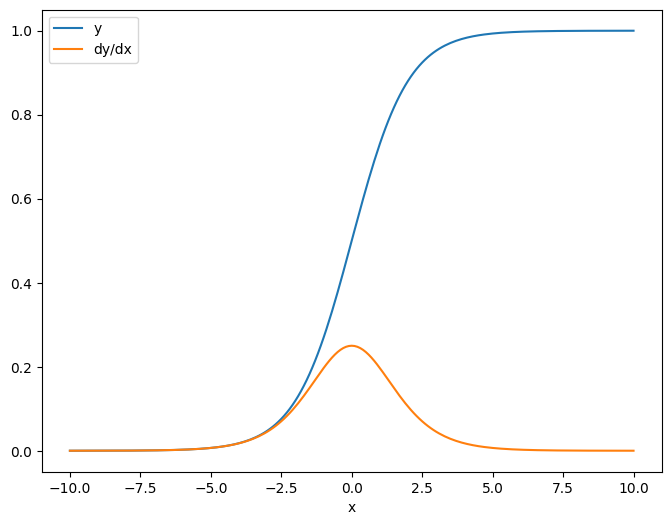

In [18]:
plt.plot(x.numpy(), y, label='y')
plt.plot(x.numpy(), dy_dx, label='dy/dx')
plt.legend()
_ = plt.xlabel('x')

### 텐서 소스

입력이 스칼라이든 텐서이든 `tf.GradientTape.jacobian`은 대상(들)의 각 요소에 대한 소스의 각 요소의 그래디언트를 효율적으로 계산합니다.

예를 들어, 이 레이어의 출력은 형상 `(10, 7)`입니다.

In [19]:
x = tf.random.normal([7, 5])
layer = tf.keras.layers.Dense(10, activation=tf.nn.relu)

with tf.GradientTape(persistent=True) as tape:
  y = layer(x)

y.shape

TensorShape([7, 10])

레이어의 커널 형상은 `(5, 10)`입니다.

In [20]:
layer.kernel.shape

TensorShape([5, 10])

커널에 대한 출력의 야고비안 형상은 서로 연결된 두 가지 형상입니다.

In [21]:
j = tape.jacobian(y, layer.kernel)
j.shape

TensorShape([7, 10, 5, 10])

대상의 차원을 합하면 `tf.GradientTape.gradient`에서 계산한 합계의 그래디언트가 남습니다.

In [22]:
g = tape.gradient(y, layer.kernel)
print('g.shape:', g.shape)

j_sum = tf.reduce_sum(j, axis=[0, 1])
delta = tf.reduce_max(abs(g - j_sum)).numpy()
assert delta < 1e-3
print('delta:', delta)

g.shape: (5, 10)
delta: 2.3841858e-07


<a id="hessian"> </a>

#### 예: Hessian

`tf.GradientTape`는 [Hessian 행렬](https://en.wikipedia.org/wiki/Hessian_matrix)을 구성하기 위한 명시적인 방법을 제공하지 않지만 `tf.GradientTape.jacobian` 메서드를 사용하여 빌드할 수 있습니다.

참고: Hessian 행렬은 `N **2` 매개변수를 포함합니다. 그 외 여러 이유로 인해 대부분의 모델에는 실용적이지 않습니다. 이 예제는 `GradientTape.jacobian` 메서드를 사용하는 방법에 대한 설명으로 포함되어 있으며 직접적인 Hessian 기반 최적화를 보증하는 것은 아닙니다. Hessian-vector 곱은 [중첩 테이프를 사용하여 효율적으로 계산](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/eager/benchmarks/resnet50/hvp_test.py)할 수 있으며 2차 최적화에 대한 훨씬 효율적인 접근 방식입니다.

In [23]:
x = tf.random.normal([7, 5])
layer1 = tf.keras.layers.Dense(8, activation=tf.nn.relu)
layer2 = tf.keras.layers.Dense(6, activation=tf.nn.relu)

with tf.GradientTape() as t2:
  with tf.GradientTape() as t1:
    x = layer1(x)
    x = layer2(x)
    loss = tf.reduce_mean(x**2)

  g = t1.gradient(loss, layer1.kernel)

h = t2.jacobian(g, layer1.kernel)

In [24]:
print(f'layer.kernel.shape: {layer1.kernel.shape}')
print(f'h.shape: {h.shape}')

layer.kernel.shape: (5, 8)
h.shape: (5, 8, 5, 8)


이 Hessian을 뉴턴의 방법 단계에 사용하려면, 먼저 축을 행렬로 평면화하고 그래디언트를 벡터로 평면화합니다.

In [25]:
n_params = tf.reduce_prod(layer1.kernel.shape)

g_vec = tf.reshape(g, [n_params, 1])
h_mat = tf.reshape(h, [n_params, n_params])

Hessian 행렬은 대칭이어야 합니다.

In [26]:
def imshow_zero_center(image, **kwargs):
  lim = tf.reduce_max(abs(image))
  plt.imshow(image, vmin=-lim, vmax=lim, cmap='seismic', **kwargs)
  plt.colorbar()

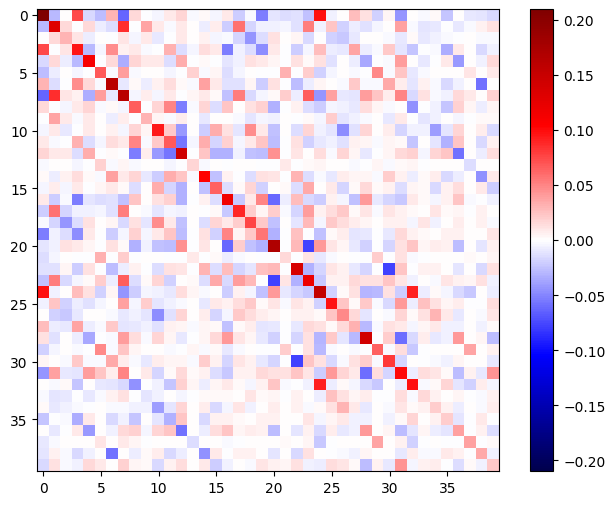

In [27]:
imshow_zero_center(h_mat)

뉴턴의 방법 업데이트 단계는 다음과 같습니다.

In [28]:
eps = 1e-3
eye_eps = tf.eye(h_mat.shape[0])*eps

참고: [실제로 행렬을 반전하지 마세요](https://www.johndcook.com/blog/2010/01/19/dont-invert-that-matrix/).

In [29]:
# X(k+1) = X(k) - (∇²f(X(k)))^-1 @ ∇f(X(k))
# h_mat = ∇²f(X(k))
# g_vec = ∇f(X(k))
update = tf.linalg.solve(h_mat + eye_eps, g_vec)

# Reshape the update and apply it to the variable.
_ = layer1.kernel.assign_sub(tf.reshape(update, layer1.kernel.shape))

단일 `tf.Variable` 경우에는 비교적 간단하지만, 사소하지 않은 모델에 적용하려면 여러 변수에 걸쳐 완전한 Hessian을 생성하기 위해 신중하게 연결하고 슬라이스해야 합니다.

### 배치 야고비안

어떤 경우에는 소스 스택과 관련하여 각 대상 스택의 야고비안을 가져오려 합니다. 여기에서 각 대상-소스 쌍의 야고비안은 독립적입니다.

예를 들어, 여기에서 입력 `x`는 `(batch, ins)` 형상이 되고, 출력 `y`는 `(batch, outs)` 형상이 됩니다.


In [30]:
x = tf.random.normal([7, 5])

layer1 = tf.keras.layers.Dense(8, activation=tf.nn.elu)
layer2 = tf.keras.layers.Dense(6, activation=tf.nn.elu)

with tf.GradientTape(persistent=True, watch_accessed_variables=False) as tape:
  tape.watch(x)
  y = layer1(x)
  y = layer2(y)

y.shape

TensorShape([7, 6])

`x`에 대한 `y`의 전체 야고비안은 `(batch, ins, outs)`만 원하는 경우에도 `(batch, ins, batch, outs)`의 형상을 가집니다.

In [31]:
j = tape.jacobian(y, x)
j.shape

TensorShape([7, 6, 7, 5])

스택에 있는 각 항목의 그래디언트가 독립적이면, 이 텐서의 모든 `(batch, batch)` 슬라이스는 대각선 행렬입니다.

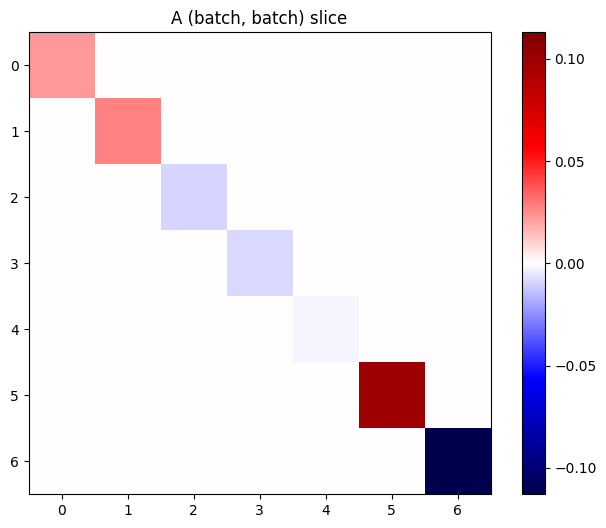

In [32]:
imshow_zero_center(j[:, 0, :, 0])
_ = plt.title('A (batch, batch) slice')

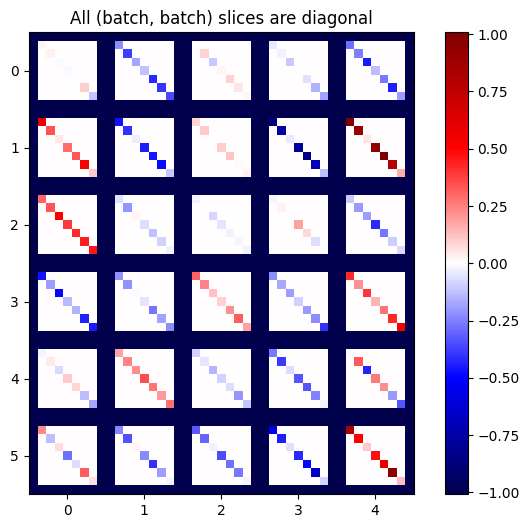

In [33]:
def plot_as_patches(j):
  # Reorder axes so the diagonals will each form a contiguous patch.
  j = tf.transpose(j, [1, 0, 3, 2])
  # Pad in between each patch.
  lim = tf.reduce_max(abs(j))
  j = tf.pad(j, [[0, 0], [1, 1], [0, 0], [1, 1]],
             constant_values=-lim)
  # Reshape to form a single image.
  s = j.shape
  j = tf.reshape(j, [s[0]*s[1], s[2]*s[3]])
  imshow_zero_center(j, extent=[-0.5, s[2]-0.5, s[0]-0.5, -0.5])

plot_as_patches(j)
_ = plt.title('All (batch, batch) slices are diagonal')

원하는 결과를 얻으려면 중복 `batch` 차원를 합산하거나 `tf.einsum`을 사용하여 대각선을 선택할 수 있습니다.

In [34]:
j_sum = tf.reduce_sum(j, axis=2)
print(j_sum.shape)
j_select = tf.einsum('bxby->bxy', j)
print(j_select.shape)

(7, 6, 5)
(7, 6, 5)


처음부터 추가 차원 없이 계산을 수행하는 것이 훨씬 더 효율적입니다. `tf.GradientTape.batch_jacobian` 메서드는 정확히 그렇게 작업을 수행합니다.

In [35]:
jb = tape.batch_jacobian(y, x)
jb.shape

TensorShape([7, 6, 5])

In [36]:
error = tf.reduce_max(abs(jb - j_sum))
assert error < 1e-3
print(error.numpy())

0.0


주의: `tf.GradientTape.batch_jacobian`은 소스 및 대상의 첫 번째 차원이 일치하는지만 확인합니다. 그래디언트가 실제로 독립적인지는 확인하지 않습니다. 적합한 경우에 `batch_jacobian`만을 사용하도록 하는 것은 여러분에게 달려 있습니다. 예를 들어, `tf.keras.layers.BatchNormalization`를 추가하면 `batch` 차원에서 정규화되므로 독립성이 없어집니다.

In [37]:
x = tf.random.normal([7, 5])

layer1 = tf.keras.layers.Dense(8, activation=tf.nn.elu)
bn = tf.keras.layers.BatchNormalization()
layer2 = tf.keras.layers.Dense(6, activation=tf.nn.elu)

with tf.GradientTape(persistent=True, watch_accessed_variables=False) as tape:
  tape.watch(x)
  y = layer1(x)
  y = bn(y, training=True)
  y = layer2(y)

j = tape.jacobian(y, x)
print(f'j.shape: {j.shape}')

j.shape: (7, 6, 7, 5)


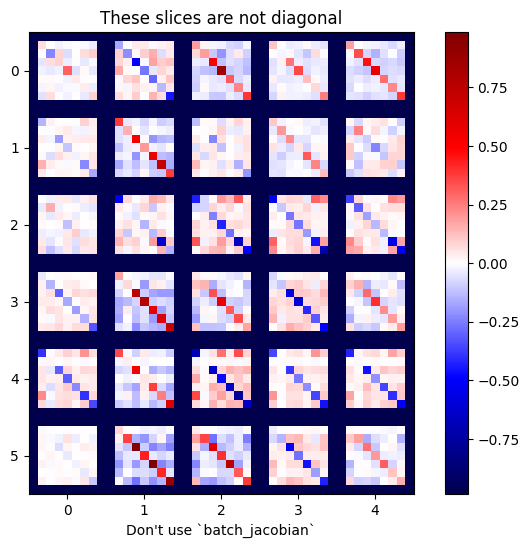

In [38]:
plot_as_patches(j)

_ = plt.title('These slices are not diagonal')
_ = plt.xlabel("Don't use `batch_jacobian`")

이 경우 `batch_jacobian`가 여전히 실행되어 예상 형상을 가진 *어떤 것*을 반환하지만 그 내용은 명확하지 않습니다.

In [39]:
jb = tape.batch_jacobian(y, x)
print(f'jb.shape: {jb.shape}')

jb.shape: (7, 6, 5)
